In [1]:
import numpy as np
import pandas as pd 
import scipy as sp 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm import tqdm

from utils import *
from plot_stats import *

from hybrid_sim import *
from hybrid_fit import * 
from hybrid_predict import *

from wsls_sim import *
from wsls_fit import *
from wsls_predict import *

from logistic_regression import *
from rnn import *
from tensorflow.python.keras.losses import binary_crossentropy

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
#config path to save data
data_path_root = f'../data'

#config num of agent to simulate
num_of_agents = 50

#config num of trails for each block
num_of_trials = 50

#config num of blocks for each agent 
num_of_block = 8

# for cross valdation 
array = np.arange(num_of_block)
cv = [np.roll(array,i) for i in range(num_of_block)]
cv = np.array(cv)

# create transtion probs
transtion_probs = np.array([[.8,.2],
                            [.2,.8]])

# config RNN hyperparameters
lr = 0.001
n_cells = 5
epochs = 400
batch_size = 50

### Model Hybrid Simulation & Fit

  0%|                                                              | 0/50 [00:00<?, ?it/s]

***** Sim Agent = 0 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  2%|█                                                   | 1/50 [01:29<1:13:29, 89.99s/it]

***** Sim Agent = 1 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  4%|██                                                  | 2/50 [02:57<1:10:59, 88.74s/it]

***** Sim Agent = 2 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  6%|███                                                 | 3/50 [04:28<1:10:03, 89.44s/it]

***** Sim Agent = 3 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  8%|████▏                                               | 4/50 [05:55<1:07:49, 88.46s/it]

***** Sim Agent = 4 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 10%|█████▏                                              | 5/50 [07:22<1:06:08, 88.18s/it]

***** Sim Agent = 5 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 12%|██████▏                                             | 6/50 [08:49<1:04:24, 87.83s/it]

***** Sim Agent = 6 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 14%|███████▎                                            | 7/50 [10:17<1:02:51, 87.70s/it]

***** Sim Agent = 7 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 16%|████████▎                                           | 8/50 [11:45<1:01:28, 87.83s/it]

***** Sim Agent = 8 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 18%|█████████▋                                            | 9/50 [13:13<59:59, 87.79s/it]

***** Sim Agent = 9 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 20%|██████████▌                                          | 10/50 [14:40<58:28, 87.71s/it]

***** Sim Agent = 10 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 22%|███████████▋                                         | 11/50 [16:08<57:01, 87.73s/it]

***** Sim Agent = 11 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 24%|████████████▋                                        | 12/50 [17:35<55:31, 87.66s/it]

***** Sim Agent = 12 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 26%|█████████████▊                                       | 13/50 [19:02<53:50, 87.30s/it]

***** Sim Agent = 13 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 28%|██████████████▊                                      | 14/50 [20:29<52:21, 87.26s/it]

***** Sim Agent = 14 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 30%|███████████████▉                                     | 15/50 [21:57<51:00, 87.45s/it]

***** Sim Agent = 15 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 32%|████████████████▉                                    | 16/50 [23:25<49:38, 87.62s/it]

***** Sim Agent = 16 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 34%|██████████████████                                   | 17/50 [24:53<48:14, 87.71s/it]

***** Sim Agent = 17 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 36%|███████████████████                                  | 18/50 [26:21<46:48, 87.75s/it]

***** Sim Agent = 18 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 38%|████████████████████▏                                | 19/50 [27:49<45:22, 87.82s/it]

***** Sim Agent = 19 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 40%|█████████████████████▏                               | 20/50 [29:16<43:53, 87.78s/it]

***** Sim Agent = 20 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 42%|██████████████████████▎                              | 21/50 [30:44<42:19, 87.57s/it]

***** Sim Agent = 21 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 44%|███████████████████████▎                             | 22/50 [32:11<40:54, 87.68s/it]

***** Sim Agent = 22 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 46%|████████████████████████▍                            | 23/50 [33:39<39:24, 87.57s/it]

***** Sim Agent = 23 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 48%|█████████████████████████▍                           | 24/50 [35:05<37:47, 87.23s/it]

***** Sim Agent = 24 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 50%|██████████████████████████▌                          | 25/50 [36:32<36:15, 87.04s/it]

***** Sim Agent = 25 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 52%|███████████████████████████▌                         | 26/50 [37:59<34:51, 87.16s/it]

***** Sim Agent = 26 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 54%|████████████████████████████▌                        | 27/50 [39:27<33:28, 87.34s/it]

***** Sim Agent = 27 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 56%|█████████████████████████████▋                       | 28/50 [40:55<32:09, 87.69s/it]

***** Sim Agent = 28 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 58%|██████████████████████████████▋                      | 29/50 [42:24<30:45, 87.87s/it]

***** Sim Agent = 29 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 60%|███████████████████████████████▊                     | 30/50 [43:51<29:14, 87.73s/it]

***** Sim Agent = 30 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 62%|████████████████████████████████▊                    | 31/50 [45:18<27:43, 87.56s/it]

***** Sim Agent = 31 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 64%|█████████████████████████████████▉                   | 32/50 [46:45<26:12, 87.35s/it]

***** Sim Agent = 32 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 66%|██████████████████████████████████▉                  | 33/50 [48:12<24:44, 87.30s/it]

***** Sim Agent = 33 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 68%|████████████████████████████████████                 | 34/50 [49:39<23:14, 87.13s/it]

***** Sim Agent = 34 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 70%|█████████████████████████████████████                | 35/50 [51:06<21:46, 87.09s/it]

***** Sim Agent = 35 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 72%|██████████████████████████████████████▏              | 36/50 [52:35<20:25, 87.51s/it]

***** Sim Agent = 36 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 74%|███████████████████████████████████████▏             | 37/50 [54:01<18:55, 87.31s/it]

***** Sim Agent = 37 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 76%|████████████████████████████████████████▎            | 38/50 [55:28<17:24, 87.02s/it]

***** Sim Agent = 38 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 78%|█████████████████████████████████████████▎           | 39/50 [56:55<15:57, 87.00s/it]

***** Sim Agent = 39 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 80%|██████████████████████████████████████████▍          | 40/50 [58:22<14:31, 87.17s/it]

***** Sim Agent = 40 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 82%|███████████████████████████████████████████▍         | 41/50 [59:50<13:06, 87.36s/it]

***** Sim Agent = 41 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 84%|██████████████████████████████████████████▊        | 42/50 [1:01:18<11:40, 87.60s/it]

***** Sim Agent = 42 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 86%|███████████████████████████████████████████▊       | 43/50 [1:02:44<10:09, 87.14s/it]

***** Sim Agent = 43 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 88%|████████████████████████████████████████████▉      | 44/50 [1:04:13<08:45, 87.56s/it]

***** Sim Agent = 44 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 90%|█████████████████████████████████████████████▉     | 45/50 [1:05:43<07:21, 88.34s/it]

***** Sim Agent = 45 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 92%|██████████████████████████████████████████████▉    | 46/50 [1:07:11<05:53, 88.26s/it]

***** Sim Agent = 46 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 94%|███████████████████████████████████████████████▉   | 47/50 [1:08:40<04:25, 88.41s/it]

***** Sim Agent = 47 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 96%|████████████████████████████████████████████████▉  | 48/50 [1:10:09<02:57, 88.52s/it]

***** Sim Agent = 48 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 98%|█████████████████████████████████████████████████▉ | 49/50 [1:11:37<01:28, 88.43s/it]

***** Sim Agent = 49 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


100%|███████████████████████████████████████████████████| 50/50 [1:13:05<00:00, 87.71s/it]


Hybrid
interaction = 0.24799127117938258
main = 0.14419052366007623
mean reward = 0.53985


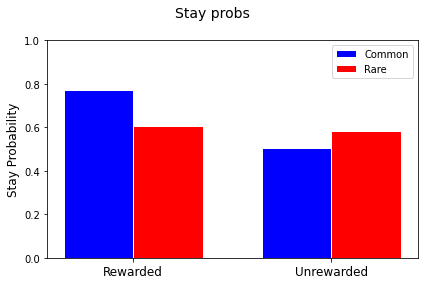

<AxesSubplot:ylabel='Stay Probability'>

In [3]:
#list to store paramters
parameters = []
data_per_agent = []

data_results = {
               'agent': [], 
               'fit_parameters_hybrid': [], 
               'train_nlp_hybrid' : [], 
               'test_acc_hybrid': [],
               'test_nlp_hybrid': [], 
    
               'fit_parameters_wsls': [], 
               'train_nlp_wsls' : [], 
               'test_acc_wsls': [],
               'test_nlp_wsls': [], 
    
               'fit_parameters_logistic_regression': [], 
               'train_nlp_logistic_regression' : [], 
               'test_acc_logistic_regression': [],
               'test_nlp_logistic_regression': [],
    
               'train_acc_rnn': [], 
               'train_nlp_rnn' : [], 
               'test_acc_rnn': [],
               'test_nlp_rnn': []
        }

# sim hybrid agent and fit on hybrid logistic_regression and RNN
for agent in tqdm(range(num_of_agents)):
    data = []
    param = configuration_parameters_hybrid()
    parameters.append(param)
    
    print(f'***** Sim Agent = {agent} *****')
    # simulations
    for i in range(num_of_block):
        reversal = np.random.choice([10,25])
        # create rewards probs 
        reward_probs = create_reward_probs(num_of_trials,reversal,0.2,0.8)
        df = hybrid_sim(
                        param,
                        num_of_trials,
                        transtion_probs,
                        reward_probs
        ) 
        data.append(df)
    data_per_agent.append(data)
    
    print(f'*** Fit ***')
    for n,t in enumerate(cv):
        data_results['agent'].append(agent)
        print(f'* loocv block {n} *')
        train_arr = t[0:-1]
        test_arr = t[-1:]
       
        # split train and test data
        train_data = [data_per_agent[agent][sim] for sim in train_arr]
        train_data = pd.concat(train_data) 
        train_data.reset_index(inplace=True)
        n_train = len(train_data)

        test_data = [data_per_agent[agent][sim] for sim in test_arr]
        test_data = pd.concat(test_data) 
        test_data.reset_index(inplace=True)
        n_test = len(test_data)

        
        print('* fit Hybrid *')
        res = hybrid_fit(train_data,3)
        data_results['fit_parameters_hybrid'].append(res.x)
        
        # Train negative log probability
        data_results['train_nlp_hybrid'].append(res.fun/n_train)
        
        # Test Accuracy and loss
        accuracy, p_0 = hybrid_predict(res.x,test_data)
        
        # Test Accuracy
        data_results['test_acc_hybrid'].append(accuracy/n_test)
        
        # Test negative log probability
        running_loss = 0
        for row in test_data.itertuples(index=True, name='Pandas'):
            running_loss += binary_crossentropy([row.action_stage_1],[1-p_0[row.Index]])
        data_results['test_nlp_hybrid'].append((running_loss/n_test).numpy())
        
        print('* fit wsls *')
        res = wsls_fit(train_data,2)
        data_results['fit_parameters_wsls'].append(res.x)
        
        # Train negative log probability
        data_results['train_nlp_wsls'].append(res.fun/n_train)
        
        # Test Accuracy and loss
        accuracy, p_0 = wsls_predict(res.x,test_data)
        
        # Test Accuracy
        data_results['test_acc_wsls'].append(accuracy/n_test)
        
        # Test negative log probability
        running_loss = 0
        for row in test_data.itertuples(index=True, name='Pandas'):
            running_loss += binary_crossentropy([row.action_stage_1],[1-p_0[row.Index]])
        data_results['test_nlp_wsls'].append((running_loss/n_test).numpy())
        
      
        print('* fit logistic_regression *')
        X , y = preprocess_logistic_regression(train_data)
        model, intercept, coef = fit_logistic_regression(X,y)
        data_results['fit_parameters_logistic_regression'].append([intercept,coef])

        # Train negative log probability
        nlp = nlp_logistic_regression(model,X,y)
        data_results['train_nlp_logistic_regression'].append((nlp/n_train).numpy())
        
        # test data 
        X, y = preprocess_logistic_regression(test_data)
        # Test Accuracy
        accuracy = model.score(X,y)
        data_results['test_acc_logistic_regression'].append(accuracy)
        
        # Test negative log probability
        nlp = nlp_logistic_regression(model,X,y)
        data_results['test_nlp_logistic_regression'].append((nlp/n_test).numpy())

        print('* fit RNN *')   
        model, sim_model, hist = train_a_model_gru(
                                              train_data,
                                              train_arr,
                                              test_data,
                                              test_arr,
                                              num_of_trials=num_of_trials,
                                              n_cells=n_cells,
                                              lr=lr,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              cp_callback=True
        )

        data_results['train_acc_rnn'].append(hist.history['accuracy'][-1])
        data_results['train_nlp_rnn'].append(hist.history['binary_crossentropy'][-1])
        data_results['test_acc_rnn'].append(hist.history['val_accuracy'][-1])
        data_results['test_nlp_rnn'].append(hist.history['val_binary_crossentropy'][-1])

        print('* on policy RNN *')
        df, _ = on_policiy_tst(
                        sim_model,
                        num_of_trials=400,
                        reversal_each_trials=100,
                        n_cells=5
        )
        df.to_csv(f'{data_path_root}/hybrid/results/rnn_on_policiy_{agent}_cv_{i}.csv')

# save data 
df = pd.DataFrame(parameters)
df.to_csv(f'{data_path_root}/hybrid/sim_data/hybrid_paramters.csv')
for a in range(num_of_agents):
    for s in range(num_of_block):
        data_per_agent[a][s].to_csv(f'{data_path_root}/hybrid/sim_data/hybrid_agent_{a}_sim_{s}.csv')
        
df = pd.DataFrame(data_results)
df.to_csv(f'{data_path_root}/hybrid/results/hybrid_fit_dataframe.csv')

X = []
for a in range(num_of_agents):
    for s in range(num_of_block):
        update_data_frame(data_per_agent[a][s])
        X.append(data_per_agent[a][s])
    
X = pd.concat(X) 
print('Hybrid')
print(f'interaction = {calc_interaction_effect(X)}')
print(f'main = {calc_main_effect(X)}')
re = X['reward'].mean()
print(f'mean reward = {re}')
plot_stay_probs(X)        

### Model wsls simulation & fit

  0%|                                                              | 0/50 [00:00<?, ?it/s]

***** Sim Agent = 0 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  2%|█                                                   | 1/50 [01:26<1:10:41, 86.57s/it]

***** Sim Agent = 1 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  4%|██                                                  | 2/50 [02:55<1:10:30, 88.14s/it]

***** Sim Agent = 2 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  6%|███                                                 | 3/50 [04:22<1:08:34, 87.55s/it]

***** Sim Agent = 3 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


  8%|████▏                                               | 4/50 [05:50<1:07:17, 87.78s/it]

***** Sim Agent = 4 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 10%|█████▏                                              | 5/50 [07:20<1:06:16, 88.37s/it]

***** Sim Agent = 5 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 12%|██████▏                                             | 6/50 [08:47<1:04:31, 87.98s/it]

***** Sim Agent = 6 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 14%|███████▎                                            | 7/50 [10:15<1:03:00, 87.93s/it]

***** Sim Agent = 7 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 16%|████████▎                                           | 8/50 [11:42<1:01:30, 87.86s/it]

***** Sim Agent = 8 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 18%|█████████▋                                            | 9/50 [13:09<59:48, 87.53s/it]

***** Sim Agent = 9 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 20%|██████████▌                                          | 10/50 [14:37<58:23, 87.58s/it]

***** Sim Agent = 10 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 22%|███████████▋                                         | 11/50 [16:04<56:50, 87.45s/it]

***** Sim Agent = 11 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 24%|████████████▋                                        | 12/50 [17:32<55:25, 87.51s/it]

***** Sim Agent = 12 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 26%|█████████████▊                                       | 13/50 [19:02<54:30, 88.38s/it]

***** Sim Agent = 13 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 28%|██████████████▊                                      | 14/50 [20:30<53:00, 88.34s/it]

***** Sim Agent = 14 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 30%|███████████████▉                                     | 15/50 [21:58<51:21, 88.05s/it]

***** Sim Agent = 15 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 32%|████████████████▉                                    | 16/50 [23:26<49:55, 88.09s/it]

***** Sim Agent = 16 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 34%|██████████████████                                   | 17/50 [24:53<48:15, 87.73s/it]

***** Sim Agent = 17 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 36%|███████████████████                                  | 18/50 [26:19<46:36, 87.40s/it]

***** Sim Agent = 18 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 38%|████████████████████▏                                | 19/50 [27:47<45:13, 87.54s/it]

***** Sim Agent = 19 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 40%|█████████████████████▏                               | 20/50 [29:14<43:35, 87.19s/it]

***** Sim Agent = 20 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 42%|██████████████████████▎                              | 21/50 [30:41<42:09, 87.22s/it]

***** Sim Agent = 21 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 44%|███████████████████████▎                             | 22/50 [32:08<40:36, 87.00s/it]

***** Sim Agent = 22 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 46%|████████████████████████▍                            | 23/50 [33:35<39:14, 87.20s/it]

***** Sim Agent = 23 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 48%|█████████████████████████▍                           | 24/50 [35:03<37:49, 87.29s/it]

***** Sim Agent = 24 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 50%|██████████████████████████▌                          | 25/50 [36:30<36:18, 87.16s/it]

***** Sim Agent = 25 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 52%|███████████████████████████▌                         | 26/50 [37:59<35:08, 87.84s/it]

***** Sim Agent = 26 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 54%|████████████████████████████▌                        | 27/50 [39:26<33:32, 87.51s/it]

***** Sim Agent = 27 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 56%|█████████████████████████████▋                       | 28/50 [40:52<31:57, 87.15s/it]

***** Sim Agent = 28 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 58%|██████████████████████████████▋                      | 29/50 [42:19<30:28, 87.08s/it]

***** Sim Agent = 29 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 60%|███████████████████████████████▊                     | 30/50 [43:45<28:55, 86.80s/it]

***** Sim Agent = 30 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 62%|████████████████████████████████▊                    | 31/50 [45:12<27:29, 86.82s/it]

***** Sim Agent = 31 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 64%|█████████████████████████████████▉                   | 32/50 [46:41<26:12, 87.37s/it]

***** Sim Agent = 32 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 66%|██████████████████████████████████▉                  | 33/50 [48:08<24:44, 87.34s/it]

***** Sim Agent = 33 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 68%|████████████████████████████████████                 | 34/50 [49:35<23:16, 87.28s/it]

***** Sim Agent = 34 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 70%|█████████████████████████████████████                | 35/50 [51:03<21:50, 87.38s/it]

***** Sim Agent = 35 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 72%|██████████████████████████████████████▏              | 36/50 [52:30<20:22, 87.34s/it]

***** Sim Agent = 36 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 74%|███████████████████████████████████████▏             | 37/50 [53:59<19:03, 87.95s/it]

***** Sim Agent = 37 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 76%|████████████████████████████████████████▎            | 38/50 [55:27<17:36, 88.02s/it]

***** Sim Agent = 38 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 78%|█████████████████████████████████████████▎           | 39/50 [56:55<16:05, 87.75s/it]

***** Sim Agent = 39 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 80%|██████████████████████████████████████████▍          | 40/50 [58:22<14:35, 87.60s/it]

***** Sim Agent = 40 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 82%|███████████████████████████████████████████▍         | 41/50 [59:49<13:08, 87.59s/it]

***** Sim Agent = 41 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 84%|██████████████████████████████████████████▊        | 42/50 [1:01:16<11:38, 87.31s/it]

***** Sim Agent = 42 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 86%|███████████████████████████████████████████▊       | 43/50 [1:02:44<10:13, 87.59s/it]

***** Sim Agent = 43 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 88%|████████████████████████████████████████████▉      | 44/50 [1:04:13<08:47, 87.86s/it]

***** Sim Agent = 44 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 90%|█████████████████████████████████████████████▉     | 45/50 [1:05:41<07:19, 87.88s/it]

***** Sim Agent = 45 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 92%|██████████████████████████████████████████████▉    | 46/50 [1:07:09<05:51, 87.91s/it]

***** Sim Agent = 46 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 94%|███████████████████████████████████████████████▉   | 47/50 [1:08:38<04:24, 88.27s/it]

***** Sim Agent = 47 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 96%|████████████████████████████████████████████████▉  | 48/50 [1:10:04<02:55, 87.66s/it]

***** Sim Agent = 48 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


 98%|█████████████████████████████████████████████████▉ | 49/50 [1:11:31<01:27, 87.62s/it]

***** Sim Agent = 49 *****
*** Fit ***
* loocv block 0 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 1 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 2 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 3 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 4 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 5 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 6 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *
* loocv block 7 *
* fit Hybrid *
* fit wsls *
* fit logistic_regression *
* fit RNN *
* on policy RNN *


100%|███████████████████████████████████████████████████| 50/50 [1:12:58<00:00, 87.58s/it]


wsls
interaction = -0.06348503922552573
main = -0.03337062586811845
mean reward = 0.4993


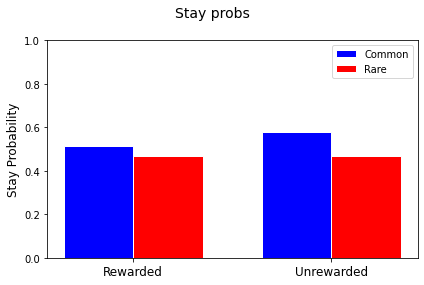

<AxesSubplot:ylabel='Stay Probability'>

In [4]:
#list to store paramters
parameters = []
data_per_agent = []

data_results = {
               'agent': [], 
               'fit_parameters_hybrid': [], 
               'train_nlp_hybrid' : [], 
               'test_acc_hybrid': [],
               'test_nlp_hybrid': [], 
    
               'fit_parameters_wsls': [], 
               'train_nlp_wsls' : [], 
               'test_acc_wsls': [],
               'test_nlp_wsls': [], 
    
               'fit_parameters_logistic_regression': [], 
               'train_nlp_logistic_regression' : [], 
               'test_acc_logistic_regression': [],
               'test_nlp_logistic_regression': [],
    
               'train_acc_rnn': [], 
               'train_nlp_rnn' : [], 
               'test_acc_rnn': [],
               'test_nlp_rnn': []
        }


# sim nwsls agent and fit on hybrid logistic_regression and RNN models
for agent in tqdm(range(num_of_agents)):
    data = []
    param = configuration_parameters_wsls()
    parameters.append(param)
    
    print(f'***** Sim Agent = {agent} *****')
    # simulations
    for i in range(num_of_block):
        reversal = np.random.choice([10,25])
        # create rewards probs 
        reward_probs = create_reward_probs(num_of_trials,reversal,0.2,0.8)
        df = wsls_sim(
                    param,
                    num_of_trials,
                    transtion_probs,
                    reward_probs
        ) 
        data.append(df)
    data_per_agent.append(data)
    
    print(f'*** Fit ***')
    # fit
    for n,t in enumerate(cv):
        data_results['agent'].append(agent)
        print(f'* loocv block {n} *')
        train_arr = t[0:-1]
        test_arr = t[-1:]
       
        # split train and test data
        train_data = [data_per_agent[agent][sim] for sim in train_arr]
        train_data = pd.concat(train_data) 
        train_data.reset_index(inplace=True)
        n_train = len(train_data)

        test_data = [data_per_agent[agent][sim] for sim in test_arr]
        test_data = pd.concat(test_data) 
        test_data.reset_index(inplace=True)
        n_test = len(test_data)

        print('* fit Hybrid *')
        res = hybrid_fit(train_data,3)
        data_results['fit_parameters_hybrid'].append(res.x)
        
        # Train negative log probability
        data_results['train_nlp_hybrid'].append(res.fun/n_train)
        
        # Test Accuracy and loss
        accuracy, p_0 = hybrid_predict(res.x,test_data)
        
        # Test Accuracy
        data_results['test_acc_hybrid'].append(accuracy/n_test)
        
        # Test negative log probability
        running_loss = 0
        for row in test_data.itertuples(index=True, name='Pandas'):
            running_loss += binary_crossentropy([row.action_stage_1],[1-p_0[row.Index]])
        data_results['test_nlp_hybrid'].append((running_loss/n_test).numpy())
        
        print('* fit wsls *')
        res = wsls_fit(train_data,2)
        data_results['fit_parameters_wsls'].append(res.x)
        
        # Train negative log probability
        data_results['train_nlp_wsls'].append(res.fun/n_train)
        
        # Test Accuracy and loss
        accuracy, p_0 = wsls_predict(res.x,test_data)
        
        # Test Accuracy
        data_results['test_acc_wsls'].append(accuracy/n_test)
        
        # Test negative log probability
        running_loss = 0
        for row in test_data.itertuples(index=True, name='Pandas'):
            running_loss += binary_crossentropy([row.action_stage_1],[1-p_0[row.Index]])
        data_results['test_nlp_wsls'].append((running_loss/n_test).numpy())
        
        print('* fit logistic_regression *')
        X , y = preprocess_logistic_regression(train_data)
        model, intercept, coef = fit_logistic_regression(X,y)
        data_results['fit_parameters_logistic_regression'].append([intercept,coef])

        # Train negative log probability
        nlp = nlp_logistic_regression(model,X,y)
        data_results['train_nlp_logistic_regression'].append((nlp/n_train).numpy())
        
        # test data 
        X, y = preprocess_logistic_regression(test_data)
        # Test Accuracy
        accuracy = model.score(X,y)
        data_results['test_acc_logistic_regression'].append(accuracy)
        
        # Test negative log probability
        nlp = nlp_logistic_regression(model,X,y)
        data_results['test_nlp_logistic_regression'].append((nlp/n_test).numpy())

        print('* fit RNN *')   
        model, sim_model, hist = train_a_model_gru(
                                              train_data,
                                              train_arr,
                                              test_data,
                                              test_arr,
                                              num_of_trials=num_of_trials,
                                              n_cells=n_cells,
                                              lr=lr,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              cp_callback=True
        )

        data_results['train_acc_rnn'].append(hist.history['accuracy'][-1])
        data_results['train_nlp_rnn'].append(hist.history['binary_crossentropy'][-1])
        data_results['test_acc_rnn'].append(hist.history['val_accuracy'][-1])
        data_results['test_nlp_rnn'].append(hist.history['val_binary_crossentropy'][-1])

        print('* on policy RNN *')
        df, _ = on_policiy_tst(
                        sim_model,
                        num_of_trials=400,
                        reversal_each_trials=100,
                        n_cells=n_cells
        )
        df.to_csv(f'{data_path_root}/wsls/results/rnn_on_policiy_{agent}_cv_{i}.csv')

# save data 
df = pd.DataFrame(parameters)
df.to_csv(f'{data_path_root}/wsls/sim_data/wsls_paramters.csv')
for a in range(num_of_agents):
    for s in range(num_of_block):
        data_per_agent[a][s].to_csv(f'{data_path_root}/wsls/sim_data/wsls_agent_{a}_sim_{s}.csv')
        
df = pd.DataFrame(data_results)
df.to_csv(f'{data_path_root}/wsls/results/wsls_fit_dataframe.csv')

X = []
for a in range(num_of_agents):
    for s in range(num_of_block):
        update_data_frame(data_per_agent[a][s])
        X.append(data_per_agent[a][s])
    
X = pd.concat(X) 
print('wsls')
print(f'interaction = {calc_interaction_effect(X)}')
print(f'main = {calc_main_effect(X)}')
re = X['reward'].mean()
print(f'mean reward = {re}')
plot_stay_probs(X)        